# Cross validation of different models

In [1]:
%matplotlib inline
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

from embeddings import *
from tools import *
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
import os.path
from tokenizer import *

# Load library
from nltk.corpus import stopwords
from gensim import *
import pickle
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import gensim.downloader as api
import re

# Data input and output paths
POS_TRAIN_PATH = '../data/twitter-datasets/train_pos_full.txt' 
NEG_TRAIN_PATH = '../data/twitter-datasets/train_neg_full.txt' 
DATA_TEST_PATH = '../data/twitter-datasets/test_data.txt'
OUTPUT_PATH = 'predictions_out.csv'

TOKENS_PATH = "../saved_gen_files/all_tokens.txt"
FULL_TRAIN_TWEET_VECTORS = "../saved_gen_files/train_tweet_vectors.txt"

## Import data

In [2]:
pos_ids, pos_text_train = load_csv_test_data(POS_TRAIN_PATH)
neg_ids, neg_text_train = load_csv_test_data(NEG_TRAIN_PATH)
full_dataset = np.concatenate((pos_text_train, neg_text_train), axis=None)
full_labels = np.concatenate((np.ones(len(pos_text_train)), -np.ones(len(pos_text_train))), axis=None)

## Tokenize

In [3]:
if os.path.isfile(TOKENS_PATH):
    with open(TOKENS_PATH, 'rb') as f:
        all_tokens = pickle.load(f)
else:    
    all_tokens = [tokenize(tweet) for tweet in full_dataset]
    
    with open(TOKENS_PATH, 'wb') as f:
        pickle.dump(all_tokens, f)

In [4]:
# Generate bigrams
#all_tokens = computeBigrams(all_tokens)

## Word Embedding

Choose one of the embedding algo and the dimensions of the vectors



In [4]:
DIM = 50

### Word2Vec

In [ ]:
wv = getWord2VecDict(all_tokens, size=DIM, window=10, min_count=2, workers=10, iters=10, train=True)

### Glove

##### pre-trained

In [7]:
wv = api.load("glove-twitter-" + str(DIM)).wv

/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


###### self-trained

In [5]:
from gensim.test.utils import datapath
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = '../data/self_trained_gloves/vectors_d'+str(DIM)+'.txt'
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

wv = KeyedVectors.load_word2vec_format(tmp_file)

# Normalize 
wv.init_sims(replace=True)

### Fastext

In [ ]:
# Train a word2vec model to generate embedding
wv = getFasttextDict(all_tokens, size=DIM, window=10, min_count=2, workers=10, iters=10, train=False)

## Model Selection

### Linear Regression

In [ ]:
# Convert tweet in features with previous embedding system
all_tweets_vectors = generateTweetsFeatures(all_tokens, wv)

In [ ]:
# Train and test the model
clf = linear_model.Ridge(alpha=0.1)
#clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test, predict_labels(predictions)))

### SVM

In [10]:
from sklearn import svm

clf_svm = svm.SVC(gamma='scale')
clf_svm.fit(tweet_padded, y_train)
predict_svm = clf_svm.predict(test_tweet_pad)
print(classification_report(y_test, predict_labels(predict_svm)))

/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00    124358
         1.0       0.57      0.90      0.70    125642

    accuracy                           0.45    250000
   macro avg       0.19      0.30      0.23    250000
weighted avg       0.29      0.45      0.35    250000



In [20]:
predict_svm_zero = predict_svm
predict_svm_zero[predict_svm_zero < 0] = 0
print(f'Simple np.mean on the predictions gives an accuracy of {np.mean(y_test == predict_svm)}')
print(classification_report(y_test, predict_labels(predict_svm_zero)))

Simple np.mean on the predictions gives an accuracy of 0.615192
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00    124358
         1.0       0.57      0.90      0.70    125642

    accuracy                           0.45    250000
   macro avg       0.19      0.30      0.23    250000
weighted avg       0.29      0.45      0.35    250000



### LSTM

In [8]:
# Force the negative sentiment to be clasified to 0 instead of 1 
labels = full_labels
labels[labels<0] = 0

all_tokens = [list(filter(lambda i: i in wv, tweet)) for tweet in all_tokens]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(all_tokens, labels, test_size=0.1, train_size=0.1)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_epochs=5

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

max_length = max([len(tweet_tokens) for tweet_tokens in X_train])

# Transform each unique word in unique int identifier
sequences = tokenizer.texts_to_sequences(X_train)


# Pad the tweet to have all the same size
tweet_padded = pad_sequences(sequences, maxlen=max_length)

# Same for test data
test_sequences = tokenizer.texts_to_sequences(X_test)
test_tweet_pad = pad_sequences(test_sequences, maxlen=max_length)

In [13]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


### First version

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Dense, Dropout, Activation, GRU, LSTM, Bidirectional, Flatten, GlobalMaxPool1D

model_name = f"BLSTM_{DIM}"

model = Sequential()

# Add the embedding layer with our trained embedding matrix
embedding_layer = Embedding(input_dim=wv.syn0.shape[0], 
                            output_dim=wv.syn0.shape[1], 
                            weights=[wv.syn0], 
                            input_length=tweet_padded.shape[1])
model.add(embedding_layer)

# Add dropout to prevent overfitting
model.add(Dropout(0.4))

# Add BiLSTM 
model.add(Bidirectional(LSTM(64, return_sequences=True)))

#self.model.add(GlobalMaxPool1D()) #Or at the same place as Flatten()
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=0.000001)

#Tensorboard informations
logdir = 'logs/' + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

#Save model in case of crashing
checkpoint_path = model_name + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, save_freq=5)

callbacks = [reduce_lr, tensorboard_callback]

model.save_weights(checkpoint_path.format(epoch=0))

model.summary()

/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # This is added back by InteractiveShellApp.init_path()
/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if sys.path[0] == '':
/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  del sys.path[0]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           119351400 
_________________________________________________________________
dropout (Dropout)            (None, 64, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 128)           84480     
_________________________________________________________________
dense (Dense)                (None, 64, 32)            4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 32)            0         
_________________________________________________________________
activation (Activation)      (None, 64, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

### Second version

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Dense, Dropout, Activation, GRU, LSTM, Bidirectional, Flatten, GlobalMaxPool1D

model_name = f"BLSTM_2_self-trained_{DIM}"

model = Sequential()

# Add the embedding layer with our trained embedding matrix
embedding_layer = Embedding(input_dim=wv.syn0.shape[0], 
                            output_dim=wv.syn0.shape[1], 
                            weights=[wv.syn0], 
                            input_length=tweet_padded.shape[1])
model.add(embedding_layer)

# Add BiLSTM 
model.add(Bidirectional(LSTM(128, return_sequences=True)))

model.add(GlobalMaxPool1D()) #Or at the same place as Flatten()
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=0.000001)

#Tensorboard informations
logdir = 'logs/' + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

#Save model in case of crashing
checkpoint_path = model_name + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, save_freq=5)

callbacks = [reduce_lr, tensorboard_callback] #Add cp_callback if we want checkpoints

model.save_weights(checkpoint_path.format(epoch=0))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  del sys.path[0]


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 93, 50)            2736900   
_________________________________________________________________
bidirectional (Bidirectional (None, 93, 256)           183296    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________________________

### Third version

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Dense, Dropout, Activation, GRU, LSTM, Bidirectional, Flatten, GlobalMaxPool1D

model_name = f"BLSTM_3_{DIM}"

model = Sequential()

# Add the embedding layer with our trained embedding matrix
embedding_layer = Embedding(input_dim=wv.syn0.shape[0], 
                            output_dim=wv.syn0.shape[1], 
                            weights=[wv.syn0], 
                            input_length=tweet_padded.shape[1])
model.add(embedding_layer)

# Add dropout to prevent overfitting
model.add(Dropout(0.4))

# Add BiLSTM 
model.add(Bidirectional(LSTM(128, return_sequences=True)))

#self.model.add(GlobalMaxPool1D()) #Or at the same place as Flatten()
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=0.000001)

#Tensorboard informations
logdir = 'logs/' + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

#Save model in case of crashing
checkpoint_path = model_name + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, save_freq=5)

callbacks = [reduce_lr, tensorboard_callback]

model.save_weights(checkpoint_path.format(epoch=0))

model.summary()

/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # This is added back by InteractiveShellApp.init_path()
/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if sys.path[0] == '':
/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  del sys.path[0]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 85, 100)           119351400 
_________________________________________________________________
dropout (Dropout)            (None, 85, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 85, 256)           234496    
_________________________________________________________________
dense (Dense)                (None, 85, 64)            16448     
_________________________________________________________________
activation (Activation)      (None, 85, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 64)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 85, 32)            2

### GRU Version

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Dense, Dropout, Activation, GRU, LSTM, Bidirectional, Flatten, GlobalMaxPool1D

model_name = f"GRU_{DIM}"

model = Sequential()

# Add the embedding layer with our trained embedding matrix
embedding_layer = Embedding(input_dim=wv.syn0.shape[0], 
                            output_dim=wv.syn0.shape[1], 
                            weights=[wv.syn0], 
                            input_length=tweet_padded.shape[1])
model.add(embedding_layer)

# Add BiLSTM 
model.add(Bidirectional(LSTM(128, return_sequences=True)))

model.add(GlobalMaxPool1D()) #Or at the same place as Flatten()
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=0.000001)

#Tensorboard informations
logdir = 'logs/' + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

#Save model in case of crashing
checkpoint_path = model_name + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, save_freq=5)

callbacks = [reduce_lr, tensorboard_callback] #Add cp_callback if we want checkpoints

model.save_weights(checkpoint_path.format(epoch=0))

model.summary()

/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # This is added back by InteractiveShellApp.init_path()
/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if sys.path[0] == '':
/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  del sys.path[0]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 77, 100)           119351400 
_________________________________________________________________
bidirectional (Bidirectional (None, 77, 256)           234496    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

### Second version no dropout

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Dense, Dropout, Activation, GRU, LSTM, Bidirectional, Flatten, GlobalMaxPool1D

model_name = f"BLSTM_2_no_dropout_{DIM}"

model = Sequential()

# Add the embedding layer with our trained embedding matrix
embedding_layer = Embedding(input_dim=wv.syn0.shape[0], 
                            output_dim=wv.syn0.shape[1], 
                            weights=[wv.syn0], 
                            input_length=tweet_padded.shape[1])
model.add(embedding_layer)

# Add BiLSTM 
model.add(Bidirectional(LSTM(128, return_sequences=True)))

model.add(GlobalMaxPool1D()) #Or at the same place as Flatten()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=0.000001)

#Tensorboard informations
logdir = 'logs/' + model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

#Save model in case of crashing
checkpoint_path = model_name + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, save_freq=5)

callbacks = [reduce_lr, tensorboard_callback] #Add cp_callback if we want checkpoints

model.save_weights(checkpoint_path.format(epoch=0))

model.summary()

/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # This is added back by InteractiveShellApp.init_path()
/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if sys.path[0] == '':
/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  del sys.path[0]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 85, 100)           119351400 
_________________________________________________________________
bidirectional (Bidirectional (None, 85, 256)           234496    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 119,604,457
Trainable params: 119,604,457
Non-trainable params: 0
__________________________________________

In [10]:
#Or we can import the model
model = tf.keras.models.load_model('models/' + model_name + '_' + str(num_epochs) +'epochs.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           119351400 
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 256)           234496    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [10]:
#In case of failure
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [ ]:
%time model.fit(tweet_padded, y_train, batch_size=512, epochs=num_epochs, validation_data=(test_tweet_pad, y_test), shuffle=True, callbacks=callbacks)

In [12]:
model.save_weights(checkpoint_path.format(epoch=num_epochs+1))

In [11]:
#Save the model if needed
model.save('models/' + model_name + '_' + str(num_epochs) +'epochs.h5')

In [12]:
print(tweet_padded.shape)

(250000, 85)


In [ ]:
model.evaluate(test_tweet_pad, y_test)

In [12]:
# Predict
predictions = model.predict([test_tweet_pad], batch_size=512)

In [13]:
opt_prob = None
f1_max = 0

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    f1 = sklearn.metrics.f1_score(y_test, (predictions > thresh).astype(int))
    print('F1 score at threshold {} is {}'.format(thresh, f1), end='\r')
    
    if f1 > f1_max:
        f1_max = f1
        opt_prob = thresh
        
print('Optimal probabilty threshold is {} for maximum F1 score {}'.format(opt_prob, f1_max))

Optimal probabilty threshold is 0.29 for maximum F1 score 0.8329020825791209


In [14]:
print(classification_report(y_test, predict_labels(predictions, opt_prob)))

/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lucas/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00    125356
         1.0       0.79      0.88      0.83    124644

    accuracy                           0.44    250000
   macro avg       0.26      0.29      0.28    250000
weighted avg       0.40      0.44      0.42    250000



## Final Prediction

In [23]:
# Retrain the model on the entire dataset
#clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
#clf.fit(all_tweets_vectors, full_labels)

# Load the data to predict
test_ids, test_x = load_csv_test_data(DATA_TEST_PATH, has_ID=True)

# Tokenize it
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
test_tokens = [tknzr.tokenize(tweet) for tweet in test_x]

# Generate vector representation
#all_tweets_vectors = np.array([generateTweetVector(model.wv, words) for words in test_tokens])
test_sequences = tokenizer.texts_to_sequences(test_tokens)
test_tweet_pad = pad_sequences(test_sequences, maxlen=max_length)

# Predict
predictions = model.predict(test_tweet_pad)

# Save predictions
create_csv_submission(test_ids, predict_labels(predictions, opt_prob), OUTPUT_PATH)

# Plots

In [52]:
import pandas as pd
import os

path = 'logs/csv'

files = os.listdir(path)

df_list = []

for file in files:
    df = pd.read_csv(os.path.join(path, file))
    df_list.append(df)

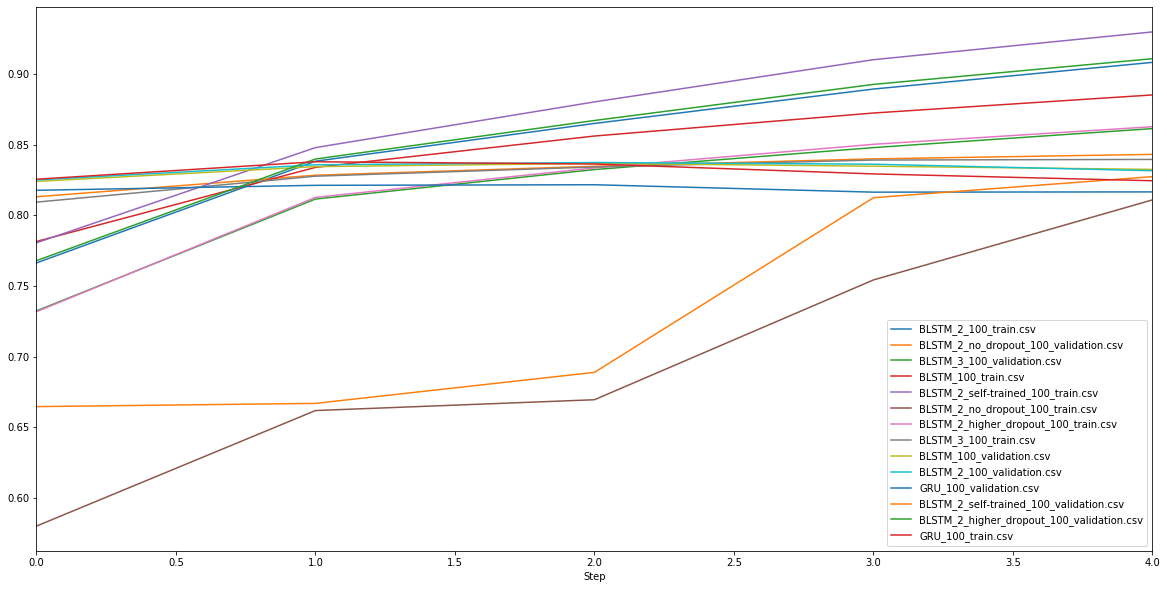

In [53]:
ax = df_list.pop().plot(kind='line', x='Step', y='Value', label=files.pop(), figsize=(20, 10))
for i, dataframe in enumerate(df_list):
    dataframe.plot(kind='line', x='Step', y='Value', label = files[i-1], ax=ax)